# Imports

In [38]:
# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pandas as pd

# PyROOT imports
#from ROOT import TTree, TFile -- cannot install ROOT using conda on Windows, using uproot instead

# SciKitHep imports
import uproot
import hist
import awkward as ak

# Setup plotting

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Get data

#### List contents of file using pyroot

In [3]:
path = '/Users/lizzi/MSci Project/ch3t_sr1_fixed.root'
#file = TFile.Open(path)
#tree = file.Get('Events')
SE_size = 47.07


#### Read data with uproot

In [44]:
# Read some or all branches into memory in an akward array

data = uproot.concatenate(f'{path}:Events'
                         # filter_name=['runID','evtID']
                         )
data.fields

['runID',
 'evtID',
 'S2_area',
 'S2_btm_area',
 'S2_top_area',
 'S2_TBA',
 'S2_corrected_area',
 'S2_XY_corrected_area',
 'S2_width_ns',
 'S2_peakAmp',
 'S2_AFT_5',
 'S2_AFT_10',
 'S2_AFT_25',
 'S2_AFT_50',
 'S2_AFT_75',
 'S2_AFT_90',
 'S2_AFT_95',
 'S2_rmsWidth_ns',
 'S2_fwhm_ns',
 'S2_x_cm',
 'S2_y_cm',
 'S2_xy_chiSq',
 'S2_n_saturated',
 'has_good_S1',
 'drift_time',
 'S1_area',
 'S1_corrected_area',
 'evt_total_area',
 'evt_bad_area',
 'evt_bad_e_area',
 'evt_bad_ph_area',
 'evt_bad_oth_area']

In [62]:
#filtering repeats

filtered_IDs = []
for ID in data.runID:
    if ID not in filtered_IDs:
        filtered_IDs.append(ID)


# Make a plot

In [143]:
# Define some useful axes

S2_axis_es = hist.axis.Regular(1000,1,100000,name="S2_axis_es",label="S2_area_es",transform=hist.axis.transform.log)
badarea_axis =hist.axis.Regular(4000,1,10000000,name="badarea_axis",label="bad",transform=hist.axis.transform.log)

x_axis = hist.axis.Regular(600,-60,60,name="x_axis",label="x",underflow=False,overflow=False)
y_axis = hist.axis.Regular(600,-60,60,name="y_axis",label="y",underflow=False,overflow=False)

In [144]:
# Define some useful cuts

r_cut = ((data.S2_x_cm**2 + data.S2_y_cm**2)**0.5 < 65)
drift_cut = ((70000 < data.drift_time) & (data.drift_time < 900000))
fiducial_cut = (r_cut & drift_cut)
S2_size_cut = ((data.S2_corrected_area/47.07 > 5) & (data.S2_corrected_area/47.07 < 200))

S2o_cut = (data.S1_corrected_area == -999)

In [145]:
# Hotspot cuts 
hs1_cut = (((data.S2_x_cm+38)**2 + (data.S2_y_cm-36)**2)**0.5 > 5)
hs2_cut = (((data.S2_x_cm+23)**2 + (data.S2_y_cm-8)**2)**0.5 > 3)
hs3_cut = (((data.S2_x_cm-4)**2 + (data.S2_y_cm-8)**2)**0.5 > 4)
hs4_cut = (((data.S2_x_cm+3)**2 + (data.S2_y_cm-8)**2)**0.5 > 2)
hs5_cut = (((data.S2_x_cm+32)**2 + (data.S2_y_cm+39)**2)**0.5 > 2)
hs6_cut = (((data.S2_x_cm-19)**2 + (data.S2_y_cm)**2)**0.5 > 2)
hs7_cut = (((data.S2_x_cm-24)**2 + (data.S2_y_cm+8)**2)**0.5 > 3)


XY_cut = hs1_cut & hs2_cut & hs3_cut & hs4_cut & hs5_cut & hs6_cut & hs7_cut & S2_size_cut
hs_cut = hs1_cut & hs2_cut & hs3_cut & hs4_cut & hs5_cut & hs6_cut & hs7_cut

[Text(0.5, 0, '$x_{S2}$ [cm]'), Text(0, 0.5, '$y_{S2}$ [cm]')]

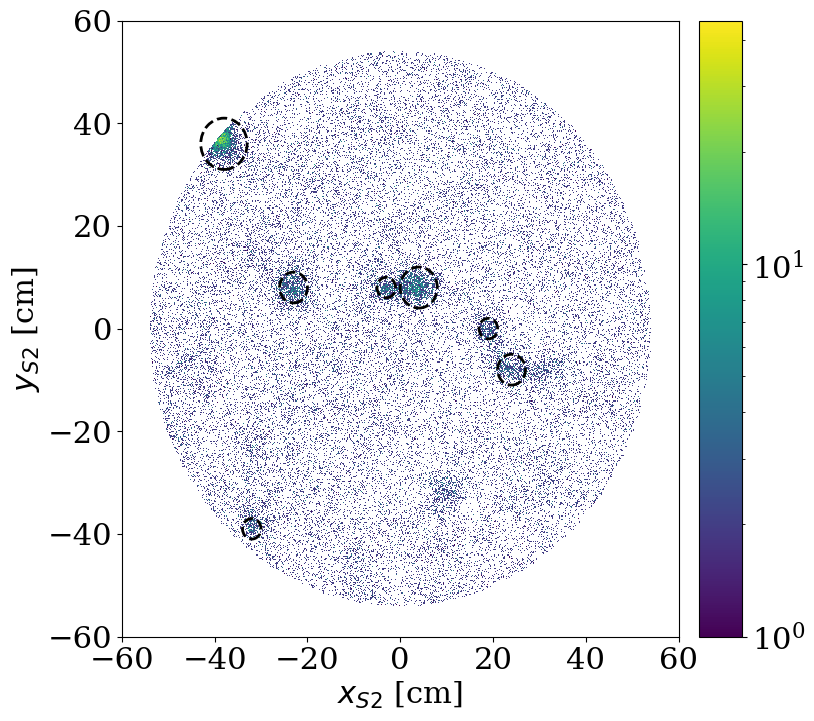

In [146]:
# X-Y histogram

fig, ax = plt.subplots(figsize=(8,8))
xy_hist = hist.Hist(x_axis,y_axis)
xy_hist.fill(data.S2_x_cm[S2_size_cut],data.S2_y_cm[S2_size_cut])
xy_hist.plot(norm=mpl.colors.LogNorm(),cmap='viridis')

hs1_cut_circ = Circle((-38,36), 5, fill=False,color='black',linewidth=2,linestyle='--')
hs2_cut_circ = Circle((-23,8), 3, fill=False,color='black',linewidth=2,linestyle='--')
hs3_cut_circ = Circle((4,8), 4, fill=False,color='black',linewidth=2,linestyle='--')
hs4_cut_circ = Circle((-3,8), 2, fill=False,color='black',linewidth=2,linestyle='--')
hs5_cut_circ = Circle((-32,-39), 2, fill=False,color='black',linewidth=2,linestyle='--')
hs6_cut_circ = Circle((19,0), 2, fill=False,color='black',linewidth=2,linestyle='--')
hs7_cut_circ = Circle((24, -8), 3, fill=False,color='black',linewidth=2,linestyle='--')

ax.add_patch(hs1_cut_circ)
ax.add_patch(hs2_cut_circ)
ax.add_patch(hs3_cut_circ)
ax.add_patch(hs4_cut_circ)
ax.add_patch(hs5_cut_circ)
ax.add_patch(hs6_cut_circ)
ax.add_patch(hs7_cut_circ)

ax.set(xlabel=r'$x_{S2}$ [cm]',ylabel=r'$y_{S2}$ [cm]')

In [100]:
# Finding IDs for hotspots 

#HS1 ( the really bright one )

hs1_cut_inside =  (((data.S2_x_cm+38)**2 + (data.S2_y_cm-36)**2)**0.5 < 5) & S2_size_cut
for ii in range(10):
    print('%i\t%i'%(data.runID[hs1_cut_inside][ii],data.evtID[hs1_cut_inside][ii]))

8139	144029
8139	30934
8141	65187
8162	31292
8145	121578
8172	54618
8167	85083
8167	85691
8167	85697
8167	85920


In [147]:
# Making rectangular cuts on badarea plot

S2_size_es = data.S2_corrected_area/SE_size

rec_cut1 = ((1.5 < S2_size_es) & (S2_size_es < 4)) & ((100 < data.evt_bad_area) & (data.evt_bad_area < 1120))
rec_cut2 = ((5 < S2_size_es) & (S2_size_es < 45)) & ((100 < data.evt_bad_area) & (data.evt_bad_area < 1300))
rec_cut3 = ((7 < S2_size_es) & (S2_size_es < 87)) & ((10000 < data.evt_bad_area) & (data.evt_bad_area < 130000))
rec_cut4 = ((80 < S2_size_es) & (S2_size_es < 680)) & ((300 < data.evt_bad_area) & (data.evt_bad_area < 3000))
rec_cut5 = ((1100 < S2_size_es) & (S2_size_es < 4100)) & ((4000 < data.evt_bad_area) & (data.evt_bad_area < 18000))

test_cut = hs_cut & rec_cut5



In [148]:
# Line cuts & combining the horizontal & diagonal data
horizontal_cut = (data.evt_bad_area < 1120) & (S2_size_es < 159.64285714285714)
diagonal_cut = (data.evt_bad_area < 7*S2_size_es + 2.5) & (S2_size_es > 159.64285714285714)
S2_range_cut = ((5 < S2_size_es) & (S2_size_es < 500))
lower_cut = horizontal_cut | diagonal_cut


[Text(0.5, 0, 'S2 Size/electrons'), Text(0, 0.5, 'Badarea'), None, None]

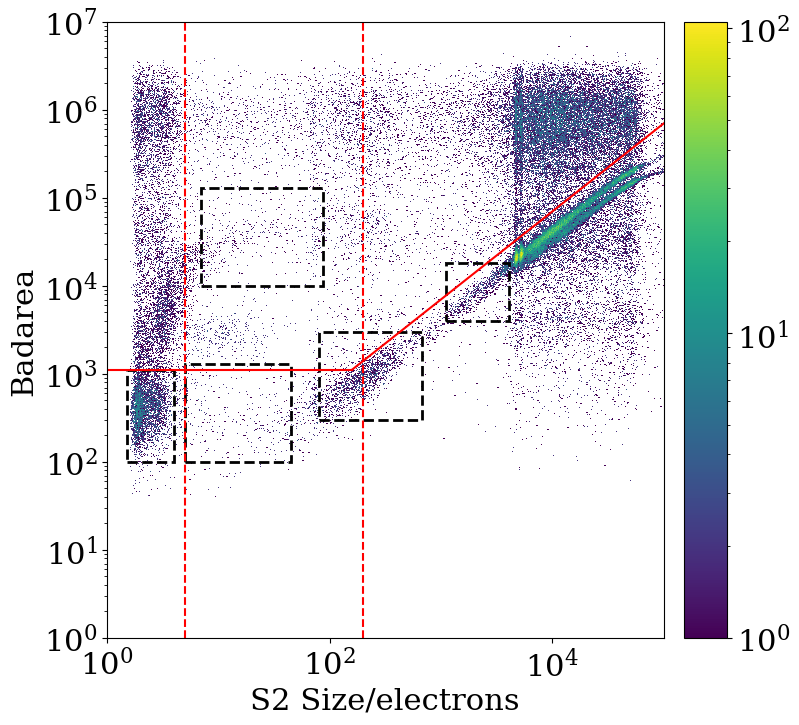

In [149]:
# Badarea hist
fig, ax = plt.subplots(figsize=(8,8))
xy_hist = hist.Hist(S2_axis_es,badarea_axis)
xy_hist.fill(S2_size_es[hs_cut],data.evt_bad_area[hs_cut])
xy_hist.plot(norm=mpl.colors.LogNorm(),cmap='viridis')

# Cut rectangles 
rec1 = Rectangle((1.5, 100),2.5,1020,fill=False,color='black',linewidth=2,linestyle='--')
rec2 = Rectangle((5, 100),40,1200,fill=False,color='black',linewidth=2,linestyle='--')
rec3 = Rectangle((7, 10000),80,120000,fill=False,color='black',linewidth=2,linestyle='--')
rec4 = Rectangle((80, 300),600,2700,fill=False,color='black',linewidth=2,linestyle='--')
rec5 = Rectangle((1100, 4000),3000,14000,fill=False,color='black',linewidth=2,linestyle='--')

ax.add_patch(rec1)
ax.add_patch(rec2)
ax.add_patch(rec3)
ax.add_patch(rec4)
ax.add_patch(rec5)

# Line cuts / drawings 

y_vert = np.logspace(0, 7, 10)
y_hor = np.full(10, 1120)
x_hor = np.linspace(0, 159.64285714285714, 10)
x_5es = np.full(10, 5)
x_200es = np.full(10, 200)
x_diag = np.linspace(159.64285714285714, 100000, 10)
y_diag = 7*x_diag + 2.5 


ax.plot(x_5es, y_vert, color = 'red', linestyle = '--')
ax.plot(x_200es, y_vert, color = 'red', linestyle = '--')
ax.plot(x_hor, y_hor, color = 'red')
ax.plot(x_diag, y_diag, color = 'red')


ax.set(xlabel=r'S2 Size/electrons',ylabel=r'Badarea', xscale='log', yscale = 'log')


In [ ]:
# Handscanning
for ii in range(10):
    print('%i\t%i'%(data.runID[rec_cut3][ii],data.evtID[rec_cut3][ii]))
    

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x000002281E2F3CA0>, cbar=<matplotlib.colorbar.Colorbar object at 0x000002281E2F3FA0>)

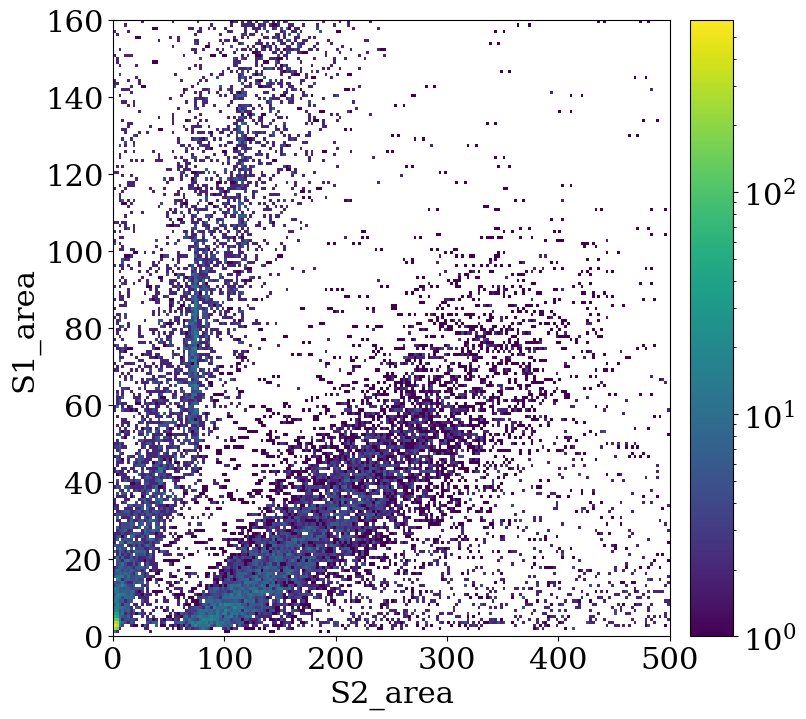

In [150]:
# S1 vs S2

S2_axis = hist.axis.Regular(200,0,500,name="S2_axis",label="S2_area",underflow=False,overflow=False)
S1_axis = hist.axis.Regular(200,0,160,name="S1_axis",label="S1_area",underflow=False,overflow=False)

fig, ax = plt.subplots(figsize=(8,8))

S2S1_hist = hist.Hist(S2_axis,S1_axis)
S2S1_hist.fill(S2_size_es[hs_cut&lower_cut], data.S1_corrected_area[hs_cut&lower_cut])
S2S1_hist.plot(norm=mpl.colors.LogNorm(),cmap='viridis')



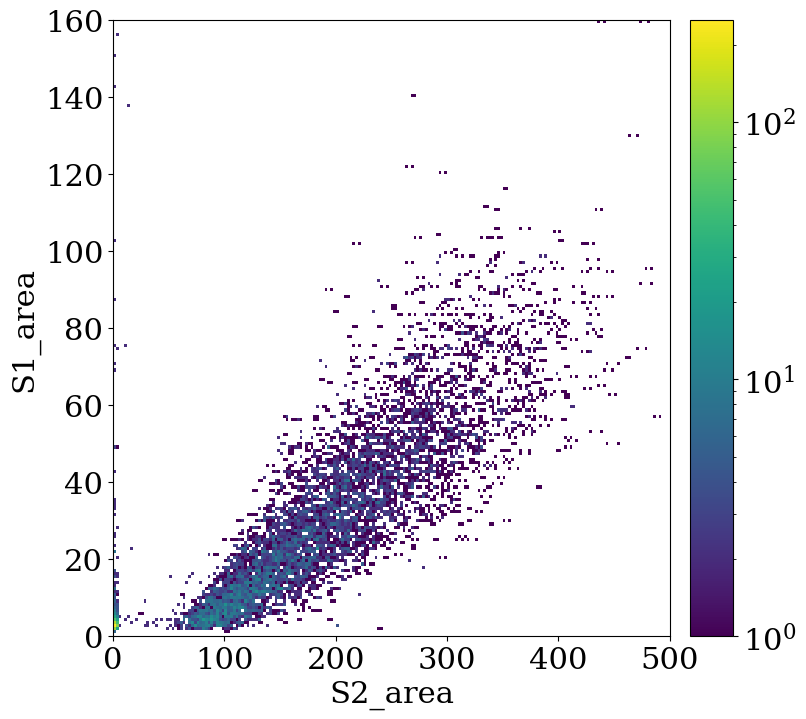

In [151]:
# S1 vs S2 w/ drif cut

drift_cut = (65000 < data.drift_time)& (data.drift_time < 900000) 
fig, ax = plt.subplots(figsize=(8,8))

S2S1_hist = hist.Hist(S2_axis,S1_axis)
S2S1_hist.fill(S2_size_es[hs_cut&drift_cut&lower_cut], data.S1_corrected_area[hs_cut&drift_cut&lower_cut])
S2S1_hist.plot(norm=mpl.colors.LogNorm(),cmap='viridis')

S1_range_cut = (data.S1_corrected_area < 140)

In [134]:
# Maths innit
(1120-2.5)/7

159.64285714285714

# ML Data 
Cuts to apply: 
- hs_cut
- S2_range_cut
- lower_cut
- S1_range_cut
- drift_cut
- radial cut - already applied to data

Processing: 
- Calculate the % time difference 
 'S2_AFT_5'
 'S2_AFT_10'
 'S2_AFT_25'
 'S2_AFT_50'
 'S2_AFT_75'
 'S2_AFT_90'
 'S2_AFT_95'

Columns Required: 
label, type, S2_peakAmp, dt05_01 etc, S2_corrected_area, x, y, r

In [152]:
ML_cut = hs_cut & S2_range_cut & lower_cut & drift_cut
data_dict = {
    'runID': data.runID[ML_cut],
    'eventID': data.evtID[ML_cut],
    'area': data.S2_corrected_area[ML_cut],
    'max_pulse_height': data.S2_peakAmp[ML_cut],
    'ext_elec': data.S2_corrected_area[ML_cut]/SE_size,
    'x' : data.S2_x_cm[ML_cut],
    'y' : data.S2_y_cm[ML_cut],
    'r' : np.sqrt((data.S2_x_cm[ML_cut])**2 + (data.S2_y_cm[ML_cut])**2)
}
df = pd.DataFrame(data_dict)
df['label'] = 2
df['type'] = 'tritium'
df.head()

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,label,type
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,2,tritium
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,2,tritium
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,2,tritium
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,2,tritium
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,2,tritium


In [153]:
# calculating the differences 
df['dt10_05']=data.S2_AFT_10[ML_cut]-data.S2_AFT_5[ML_cut]
df['dt25_10']=data.S2_AFT_25[ML_cut]-data.S2_AFT_10[ML_cut]
df['dt50_25']=data.S2_AFT_50[ML_cut]-data.S2_AFT_25[ML_cut]
df['dt75_50']=data.S2_AFT_75[ML_cut]-data.S2_AFT_50[ML_cut]
df['dt90_75']=data.S2_AFT_90[ML_cut]-data.S2_AFT_75[ML_cut]
df['dt95_90']=data.S2_AFT_95[ML_cut]-data.S2_AFT_90[ML_cut]
df.head()

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


In [154]:
df.to_csv('tritium_ML_data.csv')

23946